<a href="https://colab.research.google.com/github/PhonxayMax/Math-and-Architectures-of-Deep-Learning/blob/main/CH9_9_2_3_stochastic_gradient_descent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stochastic Gradient Descent using PyTorch

In this notebook, we demonstrate how Stochastic Gradient Descent can be implemented in PyTorch. Let us revisit the example that we discussed in section 6.8.2 where we'd like to build a model that can predict whether a Statsville resident is a man, woman or child based on height and weight data. For this purpose, let us assume we have a large dataset $X$ containing heights and weights of various Statsville residents. $X$ is of shape $(num\_samples, 2)$, where each row represents the $(height, weight)$ pair of a single resident. The corresponding labels are stored in $y\_gt$, which contains $num\_samples$ elements. Each row of $y\_gt$ can be one of $0$, $1$ or $2$ depending on whether the resident is a man, woman or child.

## Load Training Data

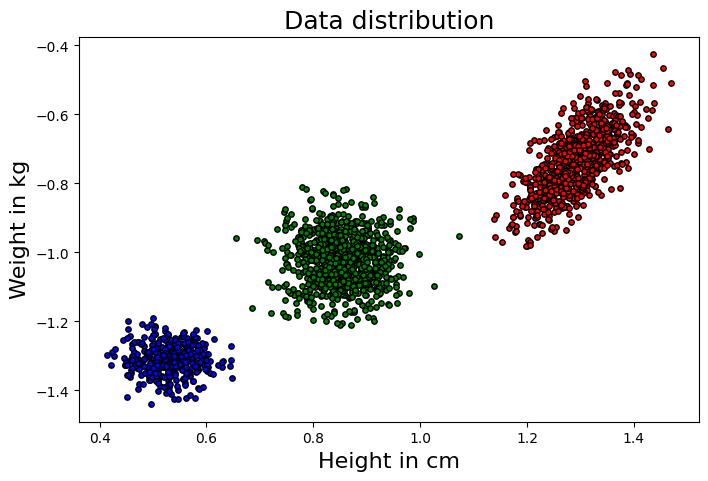

In [3]:
# Checked 19/05/2025
import torch
from torch import optim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Load the dataset
X = torch.load('X.pkl')
y_gt = torch.load('y_gt.pkl')

# We normalise the data because it brings all the inputs to the same scale. This
# helps the networks to converge better
X = (X - X.mean()) / X.std()


def plot_data(X, y_gt, title, colors=['red', 'green', 'blue'], ax=None):
    if not ax:
        fig, ax = plt.subplots(dpi=100, figsize=(8, 5))
    for X_i, y_gt_i in zip(X.tolist(), y_gt.tolist()):
        ax.scatter(X_i[0], X_i[1], c=colors[int(y_gt_i)], s=15, edgecolors='black')
    ax.set_title(title, fontsize=18)
    ax.set_xlabel("Height in cm", fontsize=16)
    ax.set_ylabel("Weight in kg", fontsize=16)


# As we can see clearly, there exist 3 distinct clusters in the underlying data
# We would expect that these clusters correspond to the 3 true classes i.e men, women and children
plot_data(X, y_gt, "Data distribution")

As you can see from the figure above, the dataset contains 3 clusters. The red cluster corresponds to class $0$ (man), the green cluster to class $1$ (woman) and the blue cluster to class $2$ (child). We expect that our classifier model, once trained, would be able to distinguish between these clusters effectively.

## Create PyTorch Dataset

Before we train a model, we first need to convert the data into a training friendly format. We subclass torch.utils.data.Dataset for the same and implement the \_\_len\_\_ and the \_\_getitem\_\_ methods. The $i^{th}$ training data instance can be accessed by calling $data\_set[i]$. Remember that in SGD, we feed in mini-batches that contain $batch\_size$ number of elements in every iteration. This can be achieved by calling \_\_getitem\_\_ $batch\_size$ number of times. However, instead of doing this ourselves, we make use of PyTorch's $DataLoader$ which gives us a convenience wrapper. It is recommended to use $DataLoader$ in production settings because it provides a simple API through which we can (i) create mini-batches, (ii) speed up data loading times via multi-processing and (iii) randomly shuffles data on every epoch to prevent overfitting.

In [4]:
from torch.utils.data import Dataset, DataLoader


class StatsvilleDataset(Dataset):
    def __init__(self, X, y_gt):
        self.X = X
        self.y_gt = y_gt

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y_gt[i]

dataset = StatsvilleDataset(X, y_gt)
data_loader = DataLoader(dataset, batch_size=10, shuffle=True)

## Create Classifier Model

Here, we create a simple Neural Network model that consists of two linear layers followed by a Softmax layer. Note that in the forward pass, we don't call the Softmax layer because the PyTorch cross-entropy loss takes in raw unnormalized scores as input. However, during prediction, we take the argmax of the softmax output to get the predicted class.

Notice that have a function to initialize the weights of the linear layers. This is important because the starting value of the weights can often affect convergence. If the model starts off too far away from the minima, it may never converge.

In [5]:
class Model(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.linear1 = torch.nn.Linear(input_size, hidden_size)
        self.linear2 = torch.nn.Linear(hidden_size, output_size)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, X):
        scores = self.linear2(self.linear1(X))
        return scores

    def predict(self, X):
        scores = self.forward(X)
        y_pred = torch.argmax(self.softmax(scores), dim=1)
        return y_pred


def initialize_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)
        torch.nn.init.constant_(m.bias.data, 0)

model = Model(input_size=2, hidden_size=100, output_size=3)
model.apply(initialize_weights)

Model(
  (linear1): Linear(in_features=2, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)

## Define Loss Function

In [6]:
loss_fn = torch.nn.CrossEntropyLoss()

## Define optimizer

For the purpose of this example, we are using an SGD based optimizer with initial learning rate of 0.02. The PyTorch interface is quite powerful in the sense that you can enable both momentum and Nesterov momentum by simply passing additional flags

In [7]:
optimizer = optim.SGD(model.parameters(), lr=0.02)

## Training Loop

Now, we define the training loop which is essentially one pass over the entire dataset. We iterate over the dataset in batches of $batch\_size$, run the forward pass, compute gradients, and update the weights in the direction of the negative gradient. Note that we call optimizer.zero_grad() in every iteration in order to prevent accumulation of gradients from the previous steps.

In [8]:
def train_loop(epoch, data_loader, model, loss_fn, optimizer):
    for batch_idx, (X_batch, y_gt_batch) in enumerate(data_loader):
        scores = model(X_batch)
        loss = loss_fn(scores, y_gt_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss

## Run Training

Now we are ready to train the model. Notice how the loss reduces every epoch and the classifier's output slowly starts becoming closer to the ground truth data distribution.

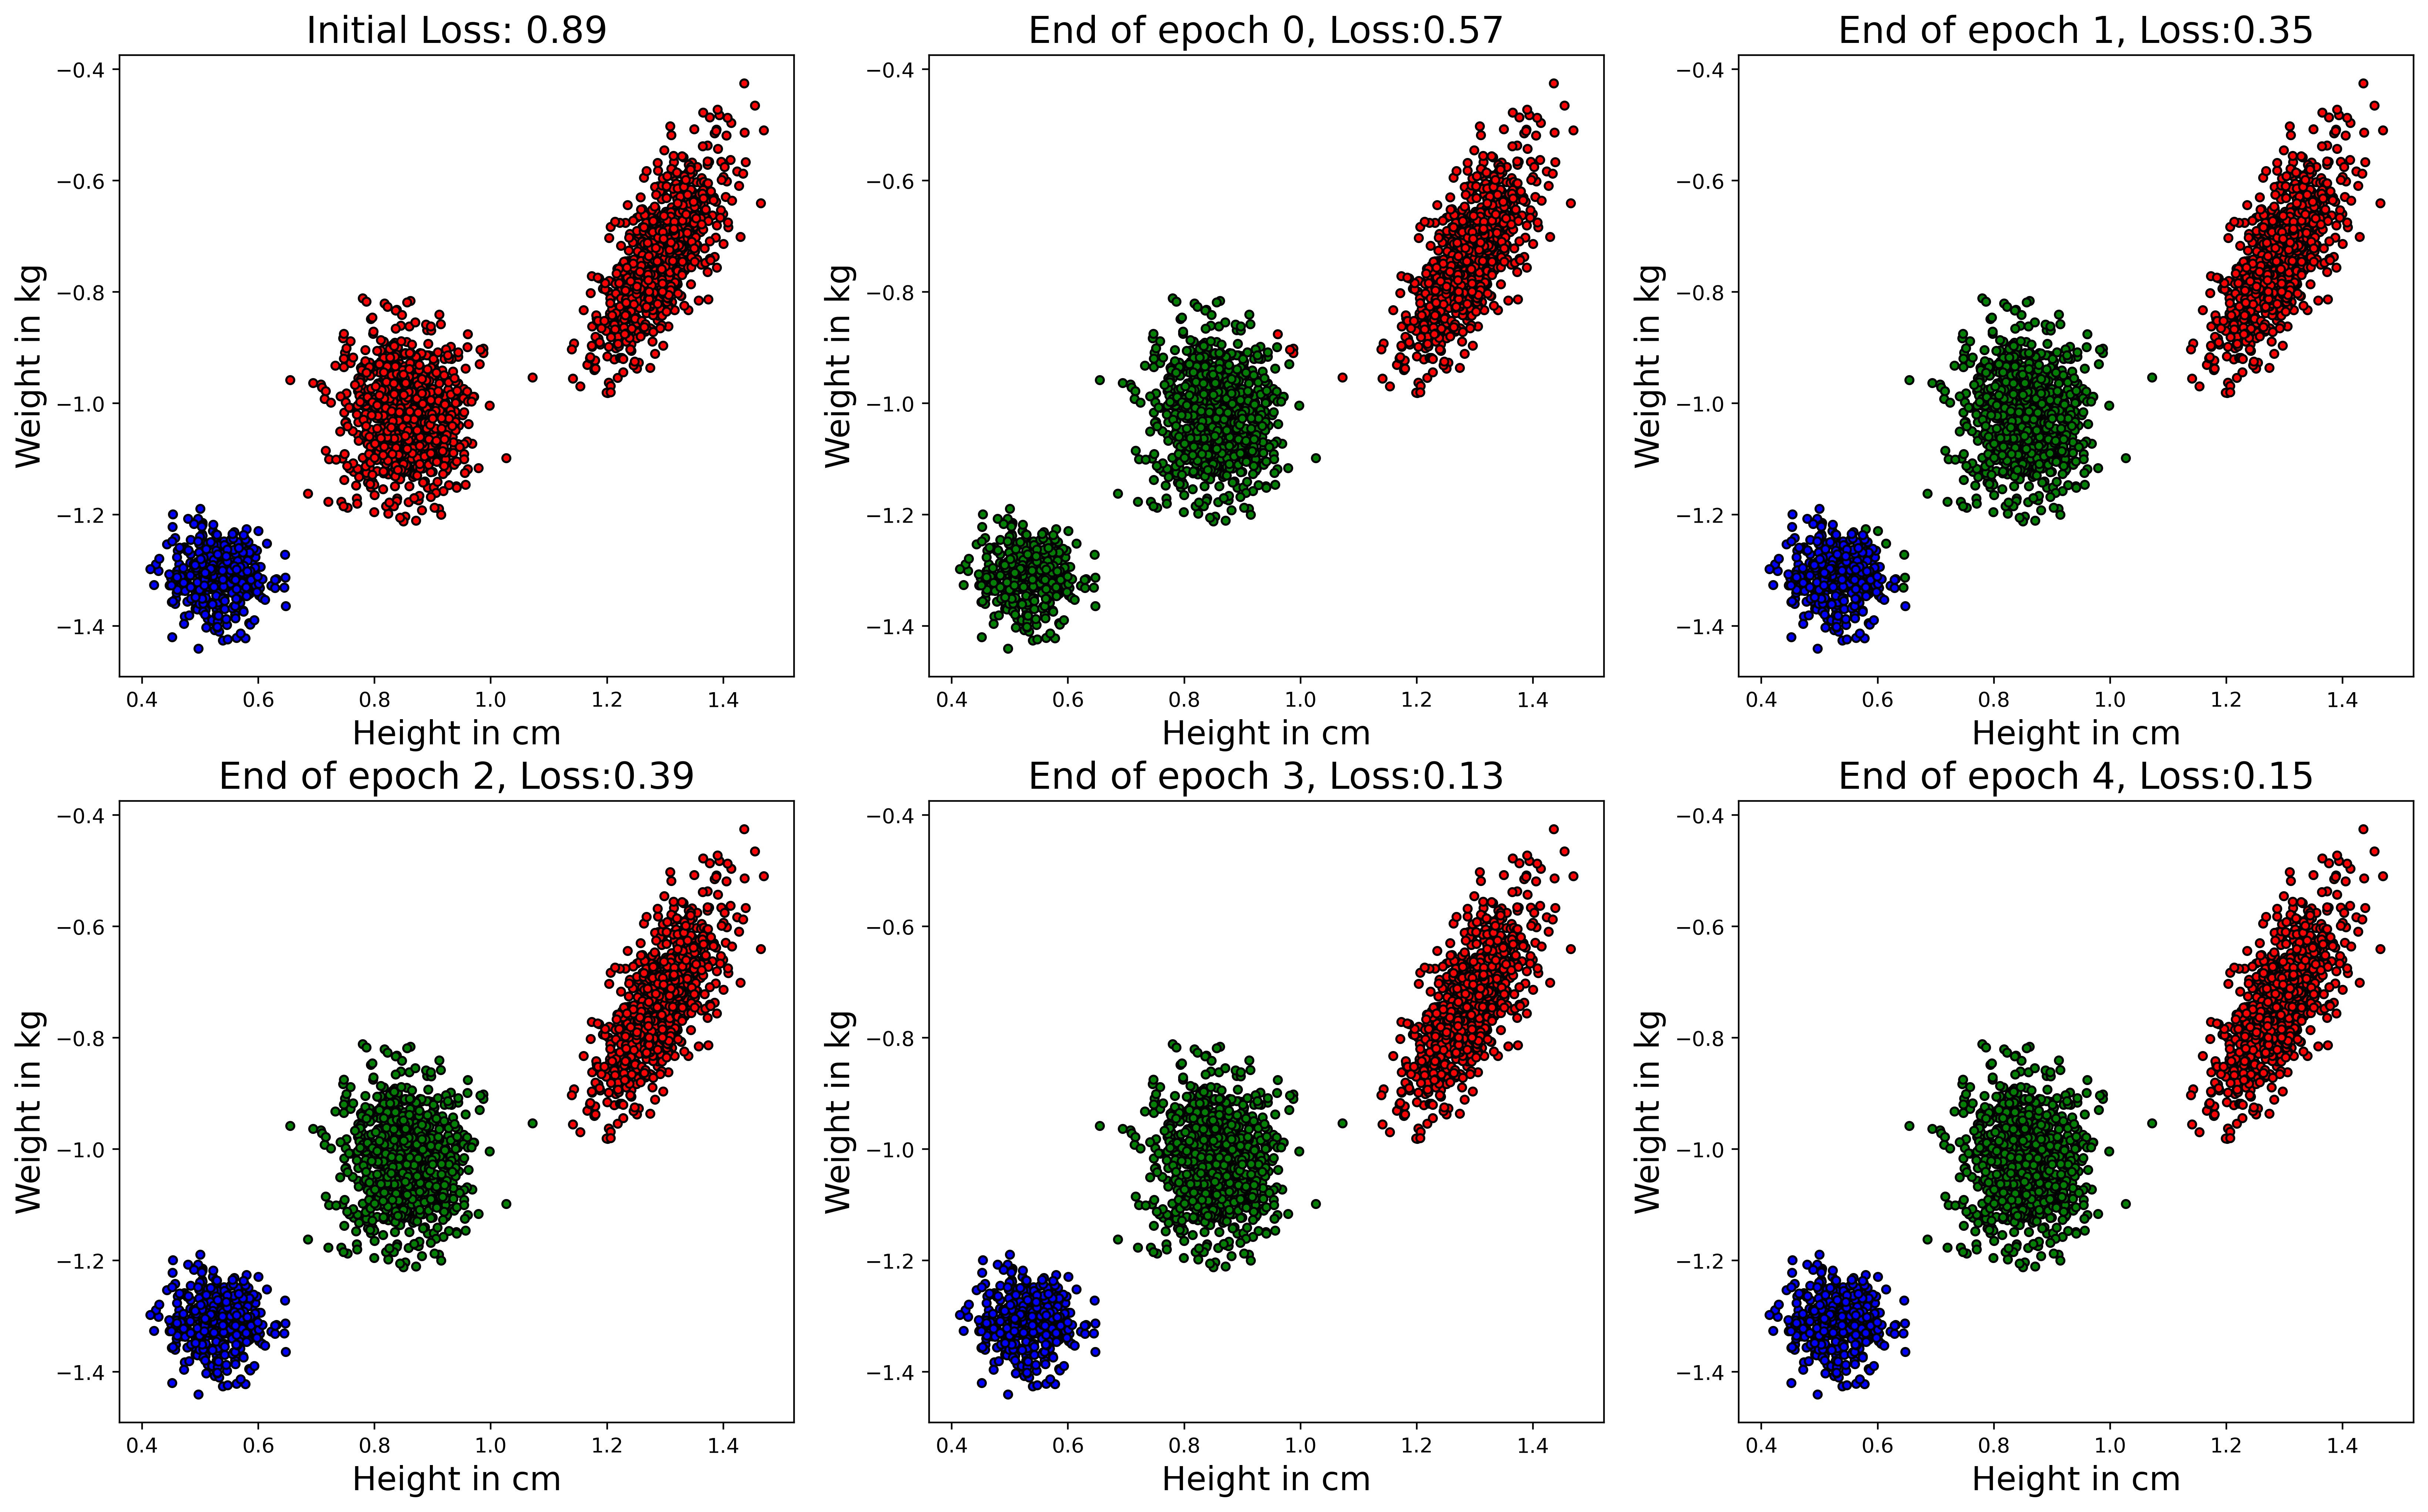

In [9]:
num_epochs = 5

fig, axs = plt.subplots(2, 3, figsize=(20, 12), dpi=400)

initial_scores = model(X)
initial_y_pred = model.predict(X)
initial_loss = loss_fn(initial_scores, initial_y_pred)
plot_data(X, initial_y_pred, "Initial Loss: {:0.2f}".format(initial_loss.data), ax=axs.flat[0])

for epoch in range(num_epochs):
    loss = train_loop(epoch, data_loader, model, loss_fn, optimizer)
    y_pred = model.predict(X)
    plot_data(X, y_pred, "End of epoch {}, Loss:{:0.2f}".format(epoch, loss.data), ax=axs.flat[epoch + 1])